In [10]:
INPUT_PATH="/ADNI/ADNI"
CSV_PATH="/ADNI/ADNI1_Complete_1Yr_1.5T_10_13_2019.csv"
OUTPUT_PATH="/ADNI/flirt_ADNI"

In [11]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [12]:
import pandas as pd
import re
import os
df = pd.read_csv(CSV_PATH)

all_files = []
for (dirpath, dirnames, filenames) in os.walk(INPUT_PATH): 
    for f in filenames: 
        if f.endswith("nii"): 
            all_files.append(int(re.split("_|\.", f)[-2][1:]))
all_files = set(all_files)
            
mci_img_ids = list(set(df.loc[df['Group'] == 'MCI']['Image Data ID'].unique()) & all_files)
cn_img_ids = list(set(df.loc[df['Group'] == 'CN']['Image Data ID'].unique())& all_files)
ad_img_ids = list(set(df.loc[df['Group'] == 'AD']['Image Data ID'].unique()) & all_files)

id_lists = {
    "mci" : mci_img_ids, 
    "cn"  : cn_img_ids, 
    "ad"  : ad_img_ids
}

logger.warning(f"MCI images {len(mci_img_ids)}, CN images {len(cn_img_ids)}, AD images {len(ad_img_ids)}")

MCI images 1036, CN images 638, AD images 445


In [13]:
import os
import nipype.interfaces.io as nio
import logging
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb
from src.preprocess import RescaleImage

In [14]:
id_lists["test"] = id_lists['ad'][:2] 

In [15]:
diagnosis = "test"
output_dir = os.path.join(OUTPUT_PATH, diagnosis)
iterables = id_lists[diagnosis]
new_shape = (192, 192, 160)
image_format='*_S_*/*/*/S*/*_I{image_id}.nii'
input_path = INPUT_PATH

In [16]:
from nipype import SelectFiles, Node, Workflow, MapNode, IdentityInterface 
from nipype.interfaces.fsl import BET, Info, FNIRT, ApplyWarp, FLIRT
from nipype.interfaces.base import BaseInterfaceInputSpec, BaseInterface, File, TraitedSpec, traits, isdefined

In [17]:
# Template coregistra
template = Info.standard_image('MNI152_T1_1mm_brain.nii.gz')
# Input
infosource = Node(IdentityInterface(fields=['image_id']),
                name="infosource")
infosource.iterables = [('image_id', iterables)]

input_node = Node(SelectFiles({'anat' : image_format},
                               base_directory=input_path),
                              name="input_node")

# Calculate coregistration 
coregistration = MapNode(FNIRT(ref_file="/ADNI/mni_icbm152_nl_VI_nifti/icbm_avg_152_t1_tal_nlin_symmetric_VI.nii",field_file=True, fieldcoeff_file=True),
                     name='fslreg',
                     iterfield=['in_file'])
# Aplicate coregistration 
apply_warp = Node(ApplyWarp(ref_file="/ADNI/mni_icbm152_nl_VI_nifti/icbm_avg_152_t1_tal_nlin_symmetric_VI.nii"),
                  name='warp', 
                  iterfield=['in_file'])

# Linear coregistration
lin_cor = Node(FLIRT(reference="/ADNI/mni_icbm152_nl_VI_nifti/icbm_avg_152_t1_tal_nlin_symmetric_VI.nii"),
                     name='flirt',iterfield=['in_file'])

# Skull stripping Node with BET
skullstrip = Node(BET(mask=True),
                  name="skullstrip",
                  iterfield=['in_file'])



# Sink
sink = Node(interface=nio.DataSink(),
            name='sink')
sink.inputs.regexp_substitutions = [("_skullstrip[0-9]+", "")]
sink.inputs.base_directory = output_dir
# Preprocess Workflow
wf = Workflow(name='preproc')
# Connections
wf.connect(infosource, "image_id", input_node, "image_id")
wf.connect(input_node, "anat", lin_cor, "in_file")
wf.connect(lin_cor, "out_file", coregistration, "in_file")
wf.connect(lin_cor, "out_file", apply_warp, "in_file")
wf.connect(coregistration, "field_file", apply_warp, "field_file")
wf.connect(apply_warp, "out_file", sink, "@out_file")

#wf.connect(apply_warp, "out_file", skullstrip, "in_file")
#wf.connect(skullstrip, "out_file",sink, "@out_file")


200313-14:54:40,335 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/thesis/graph.png (graph2use=hierarchical, simple_form=True).


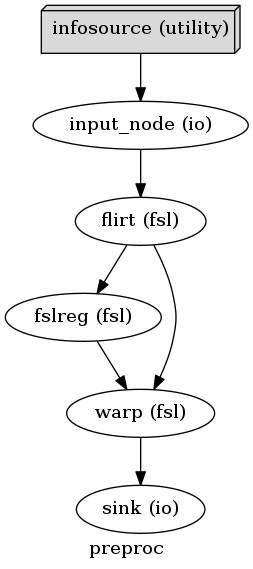

In [18]:
wf.write_graph()
from IPython.display import Image
Image('/home/neuro/thesis/graph.png')

In [19]:
iterables

[118788, 102405]

In [ ]:
wf.run(plugin='MultiProc', plugin_args={'n_procs' : 2})

200313-14:54:57,712 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
200313-14:54:58,88 nipype.workflow INFO:
	 Running in parallel.
200313-14:54:58,96 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 5.24/5.24, Free processors: 2/2.
200313-14:54:58,188 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpflq85ti1/preproc/_image_id_102405/input_node".200313-14:54:58,188 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmp8i4agp_v/preproc/_image_id_118788/input_node".

200313-14:54:58,200 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")200313-14:54:58,200 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")

200313-14:55:00,97 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 4.84/5.24, Free processors: 0/2.
                     Currently ru